# Tutorial 9: Multi Table


In this tutorial, we will perform the avatarization of data containing time series variables.

## Connection

In [19]:
import warnings

warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns 
from avatars.models import (  # noqa: E402
    AvatarizationParameters,
    JobStatus,
)

from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters
from avatars.models import ReportCreate
from avatars.models import (
    PrivacyMetricsParameters,
    TimeSeriesSignalMetricsPerDataset,
)

In [27]:
url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

In [28]:
# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

{'message': 'ok'}

## Loading data

In this tutorial, we use three data tables. Doctor, Patient and Visit. 
Each doctor ant patient is referenced in at least 1 visit

In [7]:
patient = pd.read_csv("../fixtures/table_patient.csv")
doctor = pd.read_csv("../fixtures/table_doctor.csv")
visit = pd.read_csv("../fixtures/table_visit.csv")

## Overview of data

In [11]:
patient.head()

,patient_id,gender,height,age,weight
0,0,Female,162.309578,76.703574,61.558164
1,1,Female,172.857946,70.194769,82.745473
2,2,Female,168.418504,61.589210,55.877516
3,3,Female,165.360518,66.404999,63.712823
4,4,Female,160.123873,64.679730,72.821542


<Axes: xlabel='height', ylabel='weight'>

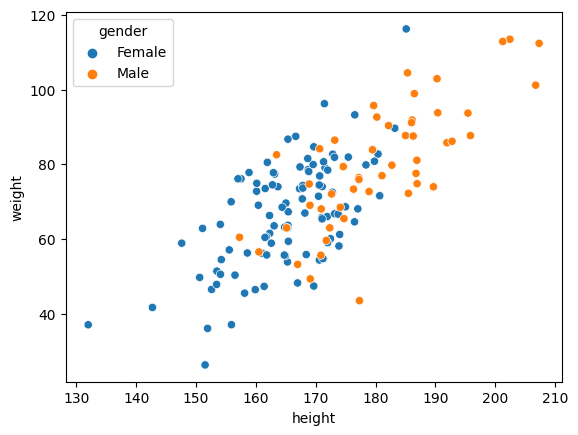

In [20]:
# plot patient height vs age and color by sex 
sns.scatterplot(patient, x="height", y="weight", hue="gender")

In [9]:
doctor.head()

,doctor_id,job,age
0,0,pediatrician,40.148021
1,1,pediatrician,39.210195
2,2,pediatrician,42.551937
3,3,pediatrician,41.370022
4,4,pediatrician,39.178037


<Axes: xlabel='job', ylabel='Count'>

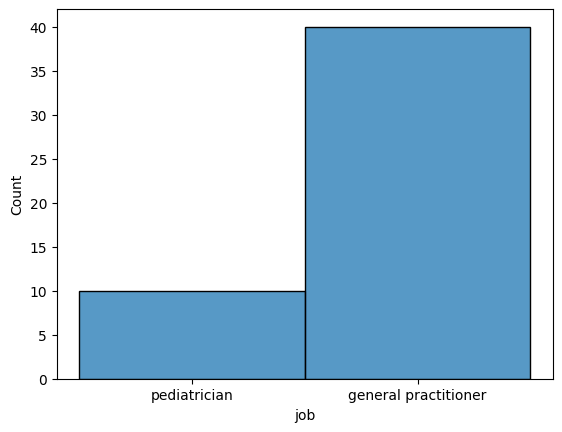

In [21]:
sns.histplot(doctor, x="job")


In [23]:
visit.head()
visit_joined = visit.merge(patient, on="patient_id", how="left")
visit_joined

,visit_id,patient_id,doctor_id,day_visit,exam,gender,height,age,weight
0,0,66,47,Tuesday,routine_check,Female,162.580905,72.714707,58.922842
1,1,149,35,Wednesday,routine_check,Male,186.913129,47.417028,81.116228
2,2,27,33,Thursday,vaccine,Female,158.118661,67.414294,45.554596
3,3,18,26,Thursday,routine_check,Female,167.302295,65.060046,73.505731
4,4,137,21,Friday,vaccine,Male,177.236460,57.060519,75.978947
...,...,...,...,...,...,...,...,...,...
295,295,118,3,Thursday,pediatrics,Male,170.864789,62.687192,55.697650
296,296,117,47,Friday,vaccine,Male,178.922298,47.095660,72.737838
297,297,69,29,Thursday,vaccine,Female,170.613982,62.747378,54.414073
298,298,88,37,Monday,vaccine,Female,165.023675,72.963210,69.656349


<Axes: xlabel='day_visit', ylabel='Count'>

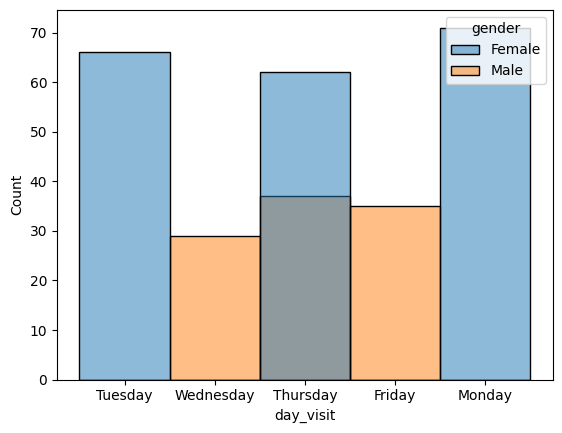

In [25]:
sns.histplot(visit_joined, x="day_visit", hue="gender")


Now that we know what data we are maniplating, we can anonymize it.

### Upload data and save datasets

In [29]:
dataset_patient  = client.pandas_integration.upload_dataframe(patient, name="patient")
dataset_doctor  = client.pandas_integration.upload_dataframe(doctor, name="doctor")
dataset_visit  = client.pandas_integration.upload_dataframe(visit, name="visit")

### Create job and retrieve results

This is done in a similar way than for the anonymization of classic tabular data. However, the objects are different. For data containing time series, it is necessary to parameterize a `AvatarizationWithTimeSeriesJobCreate` with parameters of type `AvatarizationWithTimeSeriesParameters`.

The attributes to specify in `AvatarizationWithTimeSeriesParameters` are:
- `k`
- the dataset_id of the vanilla dataset (i.e. the individual-centric dataset containing one line per individual)
- a list of `AvatarizationTimeSeriesParameters` containing 1 item per time series dataset.


Each `AvatarizationTimeSeriesParameters` specifies the dataset_id of the time series data and the projection parameters. The projection parameters defines how the data will be transformed (aka projected) so that avatars can be generated. 

Supported time series projection is Functional Principal Component Analysis (FPCA). `nf` is the number of components used to represent each time series variable in the projection.

Note that it is possible to generate avatars of data containing only time series dataset (i.e. without any vanilla data). In this case, dataset_id can be set to `None`

In [ ]:
job = client.jobs.create_avatarization_with_time_series_job(
    AvatarizationWithTimeSeriesJobCreate(
        parameters=AvatarizationWithTimeSeriesParameters(
            vanilla_dataset_id=dataset_vanilla.id,
            k=5,
            time_series=[
                AvatarizationTimeSeriesParameters(
                    dataset_id=dataset_ts.id,
                    projection_parameters=FPCAParameters(
                        nf=10,
                    ),
                )
                for dataset_ts in datasets_ts
            ],
        )
    ),
    timeout=50,
)
job = client.jobs.get_avatarization_time_series_job(job.id, timeout=60)

### Retrieve avatars

Once generated, the avatar dataset are stored on the server and can be retrieved using theuir dataset ID. The dataset ID  for each avatar dataset is contained in `job.result.datasets`.

In [ ]:
print(
    f"There are {len(job.result.datasets)} avatars datasets following anonymization.\n"
)

print(f"Their UUIDs are : {[x.avatars_dataset.id for x in job.result.datasets]}\n")

originals_to_avatars = {
    x.original_id: x.avatars_dataset.id for x in job.result.datasets
}
print(f"The mapping original to avatar is: {originals_to_avatars}")

### Checking your avatars: vanilla data 

In [ ]:
avatars_vanilla_df = client.pandas_integration.download_dataframe(
    job.result.datasets[0].avatars_dataset.id
)

In [ ]:
avatars_vanilla_df.head()

### Checking your avatars: `sensor1` and `sensor2`

In [ ]:
avatars_ts1_df = client.pandas_integration.download_dataframe(
    job.result.datasets[1].avatars_dataset.id
)

In [ ]:
plot = plot_series(
    df := avatars_ts1_df,
    variable_to_plot="sensor1",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

In [ ]:
plot = plot_series(
    df := avatars_ts1_df,
    variable_to_plot="sensor2",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

### Checking your avatars: `sensor3`

In [ ]:
avatars_ts2_df = client.pandas_integration.download_dataframe(
    job.result.datasets[2].avatars_dataset.id
)

In [ ]:
plot = plot_series(
    df := avatars_ts2_df,
    variable_to_plot="sensor3",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

## Privacy metrics for time series

As for any data, privacy metrics need to be computed on the output time series data to confirm that it is anonymous. We first retrieve the data required by the privacy metrics, that is the original datasets and their sensitive unshuffled counterparts. The unshuffled datasets are only used for computing the privacy metrics

In [ ]:
# we get the unshuffled vanilla avatars from the job result based on the original id
vanilla_unshuffled_avatars = [
    result.sensitive_unshuffled_avatars_datasets
    for result in job.result.datasets
    if result.original_id == dataset_vanilla.id
][0]

# we get the unshuffled time series avatars from the job result based on their original ids
dataset_pairs = [
    (result.original_id, result.sensitive_unshuffled_avatars_datasets)
    for result in job.result.datasets
    if result.original_id != dataset_vanilla.id
]
ts_original_ids = [pair[0] for pair in dataset_pairs]
ts_unshuffled_avatars = [pair[1] for pair in dataset_pairs]

In [ ]:
privacy_job = client.jobs.create_privacy_metrics_time_series_job(
    PrivacyMetricsWithTimeSeriesJobCreate(
        parameters=PrivacyMetricsWithTimeSeriesParameters(
            vanilla_original_id=dataset_vanilla.id,
            vanilla_unshuffled_avatars_id=vanilla_unshuffled_avatars.id,
            time_series=[
                PrivacyMetricsTimeSeriesParameters(
                    dataset_id=original_id,
                    unshuffled_avatar_dataset_id=avatar.id,
                    projection_parameters=FPCAParameters(nf=3),
                )
                for original_id, avatar in zip(ts_original_ids, ts_unshuffled_avatars)
            ],
        )
    )
)

privacy_job = client.jobs.get_privacy_metrics_time_series_job(
    privacy_job.id, timeout=10
)

Metric results are calculated for each dataset and are stored in `privacy_job.result`

In [ ]:
for metric_details in privacy_job.result.details:
    print("-------------")
    print(f"Metrics for avatar of original dataset {metric_details.original_id} are: ")
    print(metric_details)

## Signal metrics for time series data

In [ ]:
signal_job = client.jobs.create_signal_metrics_time_series_job(
    SignalMetricsWithTimeSeriesJobCreate(
        parameters=SignalMetricsWithTimeSeriesParameters(
            vanilla_original_id=dataset_vanilla.id,
            vanilla_avatars_id=vanilla_unshuffled_avatars.id,
            time_series=[
                SignalMetricsTimeSeriesParameters(
                    dataset_id=original_id,
                    avatar_dataset_id=avatar.id,
                )
                for original_id, avatar in zip(ts_original_ids, ts_unshuffled_avatars)
            ],
        )
    )
)

signal_job = client.jobs.get_signal_metrics_time_series_job(signal_job.id, timeout=10)

Metric results are calculated for each dataset and are stored in `signal_job.result`

In [ ]:
for metric_details in signal_job.result.details:
    print("-------------")
    print(f"Metrics for avatar of original dataset {metric_details.original_id} are: ")
    print(metric_details)

In [ ]:
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import matplotlib


def plot_series(
    df: pd.DataFrame,
    variable_to_plot: str,
    id_variable: str,
    time_variable: str,
    proportion_to_plot: float = 1.0,
    n_series_to_plot: Optional[int] = None,
    figsize: Tuple[int, int] = (14, 8),
) -> matplotlib.figure.Figure:
    """Plot given series."""
    if n_series_to_plot is None:
        n_series_to_plot = df[id_variable].unique().shape[0]

    df_tmp = df.copy()
    df_tmp = df_tmp.sort_values(by=[id_variable, time_variable]).reset_index(drop=True)

    cmap = matplotlib.cm.get_cmap("gist_rainbow")

    fig, ax = plt.subplots(figsize=figsize)
    for id_nb, id_name in enumerate(set(df_tmp[id_variable])):
        if id_nb > n_series_to_plot:
            break
        selected_records = df_tmp[df_tmp[id_variable] == id_name]
        n_points = int(proportion_to_plot * len(selected_records))
        selected_indices = np.linspace(0, len(selected_records) - 1, num=n_points)

        x = selected_records[time_variable].iloc[selected_indices]
        y = selected_records[variable_to_plot].iloc[selected_indices]
        ax.plot(x, y, color=cmap(id_nb / n_series_to_plot))
    ax.set_title(f"Series for variable {variable_to_plot}")
    return fig

and we use it to plot sensor data for some individuals

### `sensor1` data

In [ ]:
plot = plot_series(
    df := ts1_df,
    variable_to_plot="sensor1",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

###  `sensor2` data

In [ ]:
plot = plot_series(
    df := ts1_df,
    variable_to_plot="sensor2",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

### `sensor3` data

In [ ]:
plot = plot_series(
    df := ts2_df,
    variable_to_plot="sensor3",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

Now that we know what data we are maniplating, we can anonymize it.

## Avatars of time series data

### Upload data and save datasets

In [ ]:
dataset_vanilla = client.pandas_integration.upload_dataframe(vanilla_df)

ts_dfs = [
    ts1_df,
    ts2_df,
]  # we put all time series dataframes in a list to simplify further operations
datasets_ts = []
for ts_df in ts_dfs:
    datasets_ts.append(client.pandas_integration.upload_dataframe(ts_df))

### Create job and retrieve results

This is done in a similar way than for the anonymization of classic tabular data. However, the objects are different. For data containing time series, it is necessary to parameterize a `AvatarizationWithTimeSeriesJobCreate` with parameters of type `AvatarizationWithTimeSeriesParameters`.

The attributes to specify in `AvatarizationWithTimeSeriesParameters` are:
- `k`
- the dataset_id of the vanilla dataset (i.e. the individual-centric dataset containing one line per individual)
- a list of `AvatarizationTimeSeriesParameters` containing 1 item per time series dataset.


Each `AvatarizationTimeSeriesParameters` specifies the dataset_id of the time series data and the projection parameters. The projection parameters defines how the data will be transformed (aka projected) so that avatars can be generated. 

Supported time series projection is Functional Principal Component Analysis (FPCA). `nf` is the number of components used to represent each time series variable in the projection.

Note that it is possible to generate avatars of data containing only time series dataset (i.e. without any vanilla data). In this case, dataset_id can be set to `None`

In [ ]:
job = client.jobs.create_avatarization_with_time_series_job(
    AvatarizationWithTimeSeriesJobCreate(
        parameters=AvatarizationWithTimeSeriesParameters(
            vanilla_dataset_id=dataset_vanilla.id,
            k=5,
            time_series=[
                AvatarizationTimeSeriesParameters(
                    dataset_id=dataset_ts.id,
                    projection_parameters=FPCAParameters(
                        nf=10,
                    ),
                )
                for dataset_ts in datasets_ts
            ],
        )
    ),
    timeout=50,
)
job = client.jobs.get_avatarization_time_series_job(job.id, timeout=60)

### Retrieve avatars

Once generated, the avatar dataset are stored on the server and can be retrieved using theuir dataset ID. The dataset ID  for each avatar dataset is contained in `job.result.datasets`.

In [ ]:
print(
    f"There are {len(job.result.datasets)} avatars datasets following anonymization.\n"
)

print(f"Their UUIDs are : {[x.avatars_dataset.id for x in job.result.datasets]}\n")

originals_to_avatars = {
    x.original_id: x.avatars_dataset.id for x in job.result.datasets
}
print(f"The mapping original to avatar is: {originals_to_avatars}")

### Checking your avatars: vanilla data 

In [ ]:
avatars_vanilla_df = client.pandas_integration.download_dataframe(
    job.result.datasets[0].avatars_dataset.id
)

In [ ]:
avatars_vanilla_df.head()

### Checking your avatars: `sensor1` and `sensor2`

In [ ]:
avatars_ts1_df = client.pandas_integration.download_dataframe(
    job.result.datasets[1].avatars_dataset.id
)

In [ ]:
plot = plot_series(
    df := avatars_ts1_df,
    variable_to_plot="sensor1",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

In [ ]:
plot = plot_series(
    df := avatars_ts1_df,
    variable_to_plot="sensor2",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

### Checking your avatars: `sensor3`

In [ ]:
avatars_ts2_df = client.pandas_integration.download_dataframe(
    job.result.datasets[2].avatars_dataset.id
)

In [ ]:
plot = plot_series(
    df := avatars_ts2_df,
    variable_to_plot="sensor3",
    id_variable="id",
    time_variable="t",
    proportion_to_plot=1.0,
    n_series_to_plot=None,
    figsize=(14, 8),
)
plot.show()

## Privacy metrics for time series

As for any data, privacy metrics need to be computed on the output time series data to confirm that it is anonymous. We first retrieve the data required by the privacy metrics, that is the original datasets and their sensitive unshuffled counterparts. The unshuffled datasets are only used for computing the privacy metrics

In [ ]:
# we get the unshuffled vanilla avatars from the job result based on the original id
vanilla_unshuffled_avatars = [
    result.sensitive_unshuffled_avatars_datasets
    for result in job.result.datasets
    if result.original_id == dataset_vanilla.id
][0]

# we get the unshuffled time series avatars from the job result based on their original ids
dataset_pairs = [
    (result.original_id, result.sensitive_unshuffled_avatars_datasets)
    for result in job.result.datasets
    if result.original_id != dataset_vanilla.id
]
ts_original_ids = [pair[0] for pair in dataset_pairs]
ts_unshuffled_avatars = [pair[1] for pair in dataset_pairs]

In [ ]:
privacy_job = client.jobs.create_privacy_metrics_time_series_job(
    PrivacyMetricsWithTimeSeriesJobCreate(
        parameters=PrivacyMetricsWithTimeSeriesParameters(
            vanilla_original_id=dataset_vanilla.id,
            vanilla_unshuffled_avatars_id=vanilla_unshuffled_avatars.id,
            time_series=[
                PrivacyMetricsTimeSeriesParameters(
                    dataset_id=original_id,
                    unshuffled_avatar_dataset_id=avatar.id,
                    projection_parameters=FPCAParameters(nf=3),
                )
                for original_id, avatar in zip(ts_original_ids, ts_unshuffled_avatars)
            ],
        )
    )
)

privacy_job = client.jobs.get_privacy_metrics_time_series_job(
    privacy_job.id, timeout=10
)

Metric results are calculated for each dataset and are stored in `privacy_job.result`

In [ ]:
for metric_details in privacy_job.result.details:
    print("-------------")
    print(f"Metrics for avatar of original dataset {metric_details.original_id} are: ")
    print(metric_details)

## Signal metrics for time series data

In [ ]:
signal_job = client.jobs.create_signal_metrics_time_series_job(
    SignalMetricsWithTimeSeriesJobCreate(
        parameters=SignalMetricsWithTimeSeriesParameters(
            vanilla_original_id=dataset_vanilla.id,
            vanilla_avatars_id=vanilla_unshuffled_avatars.id,
            time_series=[
                SignalMetricsTimeSeriesParameters(
                    dataset_id=original_id,
                    avatar_dataset_id=avatar.id,
                )
                for original_id, avatar in zip(ts_original_ids, ts_unshuffled_avatars)
            ],
        )
    )
)

signal_job = client.jobs.get_signal_metrics_time_series_job(signal_job.id, timeout=10)

Metric results are calculated for each dataset and are stored in `signal_job.result`

In [ ]:
for metric_details in signal_job.result.details:
    print("-------------")
    print(f"Metrics for avatar of original dataset {metric_details.original_id} are: ")
    print(metric_details)